In [1]:
#Imports and global settings

In [110]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb


In [111]:
# Plot styling

In [112]:
plt.rcParams['figure.figsize'] = (12,5)
sns.set_style("whitegrid")

In [113]:
#  Load Your Dataset

In [114]:
data_path = "Uber-Jan-Feb-FOIL (1).csv"   # <- file name same rakho
uber = pd.read_csv(data_path)
print(uber.head())

  dispatching_base_number      date  active_vehicles  trips
0                  B02512  1/1/2015              190   1132
1                  B02765  1/1/2015              225   1765
2                  B02764  1/1/2015             3427  29421
3                  B02682  1/1/2015              945   7679
4                  B02617  1/1/2015             1228   9537


In [115]:
#Preprocessing
# Convert 'date' to datetime

In [116]:
uber['date'] = pd.to_datetime(uber['date'], errors='coerce')

In [117]:
# Sort by date
uber = uber.sort_values('date').reset_index(drop=True)

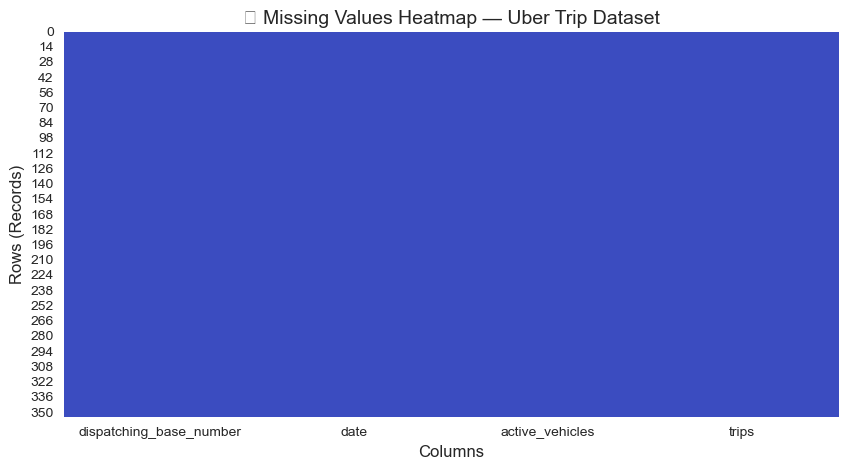

In [118]:
# Check missing values
plt.figure(figsize=(10,5))
sns.heatmap(uber.isnull(), cbar=False, cmap='coolwarm')
plt.title("🚦 Missing Values Heatmap — Uber Trip Dataset", fontsize=14)
plt.xlabel("Columns", fontsize=12)
plt.ylabel("Rows (Records)", fontsize=12)
plt.show()

In [119]:
# Extracting useful time features from the date
uber['day'] = uber['date'].dt.day
uber['month'] = uber['date'].dt.month
uber['day_of_week'] = uber['date'].dt.dayofweek 

In [120]:
daily_df = uber.groupby('date', as_index=False).agg({
    'active_vehicles': 'sum',
    'trips': 'sum'
})


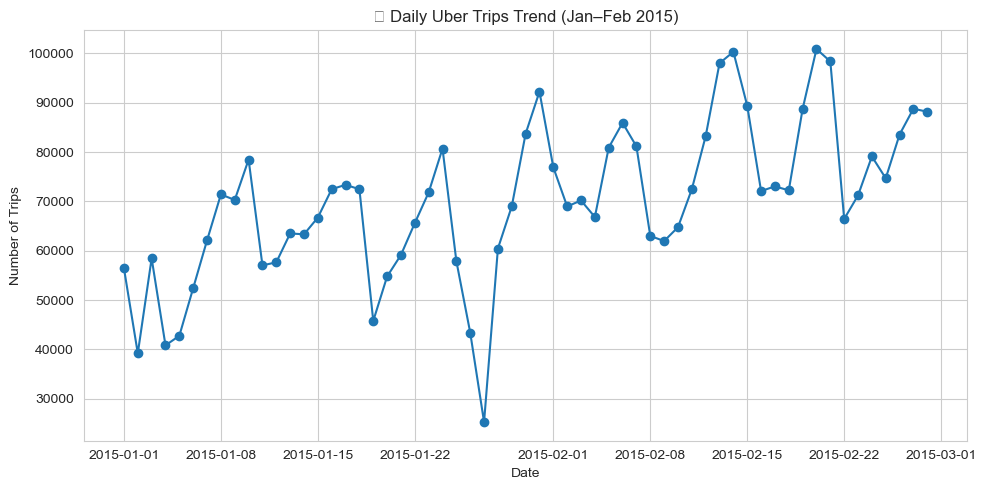

In [121]:
# EDA - Visualization

plt.figure(figsize=(10, 5))
plt.plot(daily_df['date'], daily_df['trips'], marker='o')
plt.title("📈 Daily Uber Trips Trend (Jan–Feb 2015)")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.tight_layout()
plt.show()

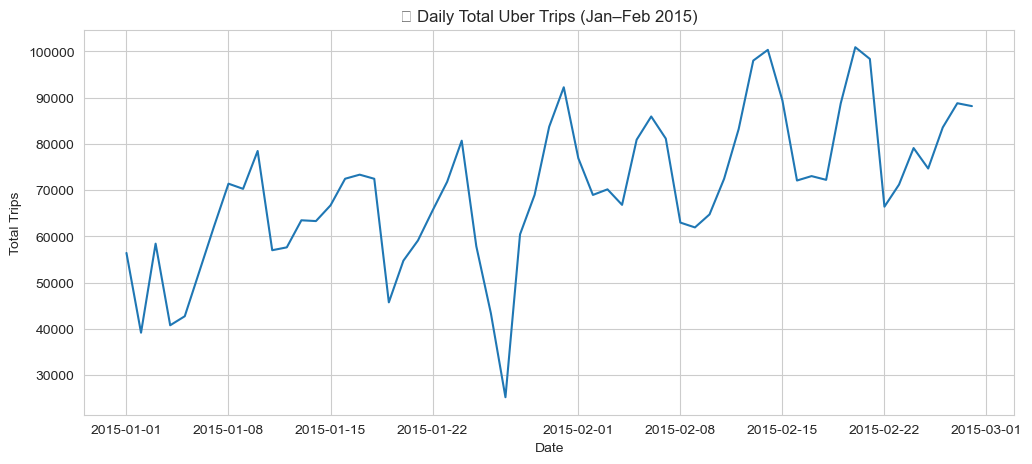

In [122]:
 # Aggregate total trips per day
# ==========================================
daily_trips = uber.groupby('date')['trips'].sum().reset_index()
daily_trips.columns = ['date', 'total_trips']

plt.plot(daily_trips['date'], daily_trips['total_trips'])
plt.title("📈 Daily Total Uber Trips (Jan–Feb 2015)")
plt.xlabel("Date")
plt.ylabel("Total Trips")
plt.show()

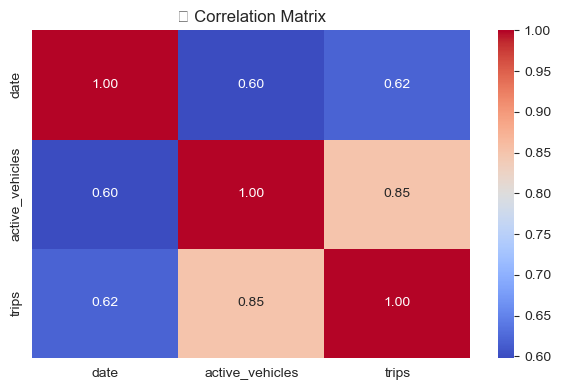

In [123]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(daily_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔗 Correlation Matrix")
plt.tight_layout()
plt.show()

In [124]:
# Create lag feature (previous day trips)
daily_df['prev_day_trips'] = daily_df['trips'].shift(1)
daily_df.dropna(inplace=True)

In [125]:
# Define features (X) and target (y)
X = daily_df[['active_vehicles', 'prev_day_trips']]
y = daily_df['trips']

In [126]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
# Model training
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [128]:
# Prediction
y_pred = rf_model.predict(X_test)

In [129]:
#Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n🎯 Model Evaluation Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.3f}")


🎯 Model Evaluation Results:
Mean Absolute Error (MAE): 7395.62
R² Score: 0.716


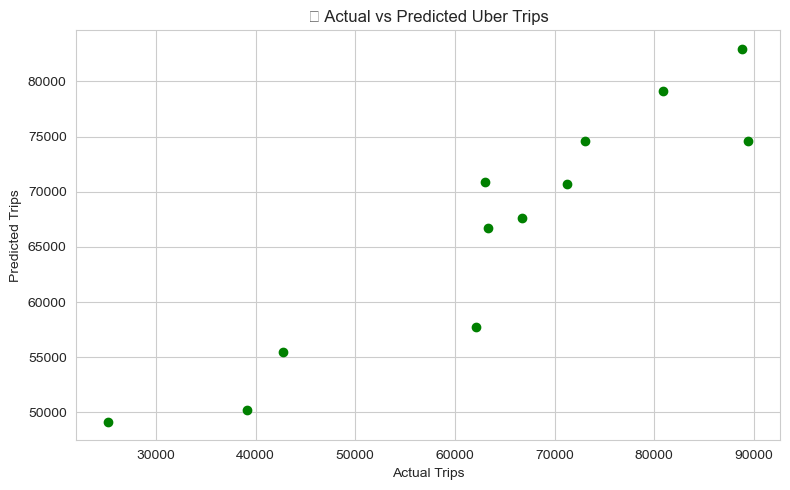

In [130]:
# Visualization of Actual vs Predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='green')
plt.xlabel("Actual Trips")
plt.ylabel("Predicted Trips")
plt.title("📊 Actual vs Predicted Uber Trips")
plt.grid(True)
plt.tight_layout()
plt.show()

In [131]:
 #Feature Engineering

# ==========================================
df = daily_trips.copy()
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.dayofweek  # 0=Mon,6=Sun
df['month'] = df['date'].dt.month

Training range: 2015-01-01 00:00:00 → 2015-02-15 00:00:00
Testing range:  2015-02-16 00:00:00 → 2015-02-28 00:00:00


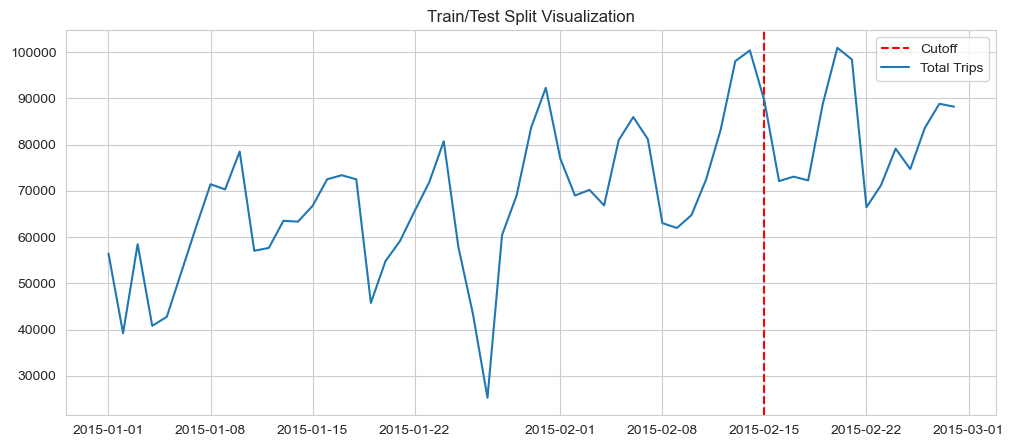

In [132]:
 #Train–Test Split (Time-based)

# ==========================================
cutoff_date = pd.to_datetime("2015-02-15")
train = df[df['date'] <= cutoff_date]
test = df[df['date'] > cutoff_date]

print(f"Training range: {train['date'].min()} → {train['date'].max()}")
print(f"Testing range:  {test['date'].min()} → {test['date'].max()}")

plt.axvline(cutoff_date, color='red', linestyle='--', label='Cutoff')
plt.plot(df['date'], df['total_trips'], label='Total Trips')
plt.legend(); plt.title("Train/Test Split Visualization"); plt.show()

In [133]:
 #Create Lag Features

# ==========================================
def create_lags(data, target_col, lags=3):
    for i in range(1, lags+1):
        data[f'lag_{i}'] = data[target_col].shift(i)
    return data.dropna()

df_lag = create_lags(df, 'total_trips', lags=3)

X = df_lag[['lag_1', 'lag_2', 'lag_3', 'day', 'weekday', 'month']]
y = df_lag['total_trips']

split_index = int(len(df_lag) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (44, 6) Test size: (12, 6)


In [134]:
# parse datetime (file has column 'date' as observed)

In [135]:

df['datetime'] = pd.to_datetime(df['date'], errors='coerce')
print("Null datetimes:", df['datetime'].isna().sum())
df = df.dropna(subset=['datetime']).reset_index(drop=True)
print("After drop shape:", df.shape)
df[['date','datetime']].head()


Null datetimes: 0
After drop shape: (59, 9)


,date,datetime
0,2015-01-01,2015-01-01
1,2015-01-02,2015-01-02
2,2015-01-03,2015-01-03
3,2015-01-04,2015-01-04
4,2015-01-05,2015-01-05


In [136]:
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df[['datetime','hour','dayofweek','month']].head()


,datetime,hour,dayofweek,month
0,2015-01-01,0,3,1
1,2015-01-02,0,4,1
2,2015-01-03,0,5,1
3,2015-01-04,0,6,1
4,2015-01-05,0,0,1


In [137]:
df = df.sort_values('datetime').set_index('datetime')
hourly = df.resample('H').size().rename('count').to_frame()
hourly = hourly.fillna(0)
hourly.head(24)


,count
datetime,
2015-01-01 00:00:00,1
2015-01-01 01:00:00,0
2015-01-01 02:00:00,0
2015-01-01 03:00:00,0
2015-01-01 04:00:00,0
2015-01-01 05:00:00,0
2015-01-01 06:00:00,0
2015-01-01 07:00:00,0
2015-01-01 08:00:00,0


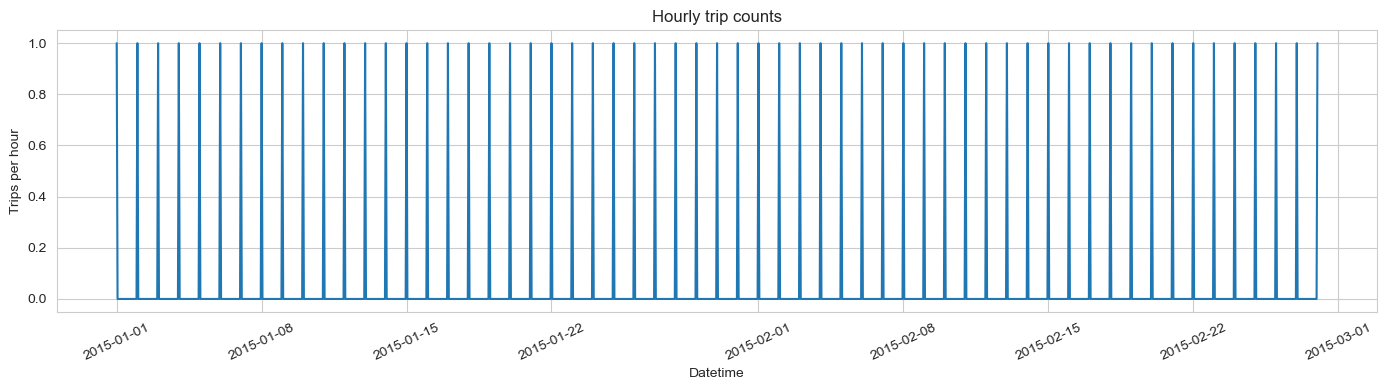

In [138]:
# Plot trips per hour (single plot)
plt.figure(figsize=(14,4))
plt.plot(hourly.index, hourly['count'])
plt.title("Hourly trip counts")
plt.xlabel("Datetime")
plt.ylabel("Trips per hour")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

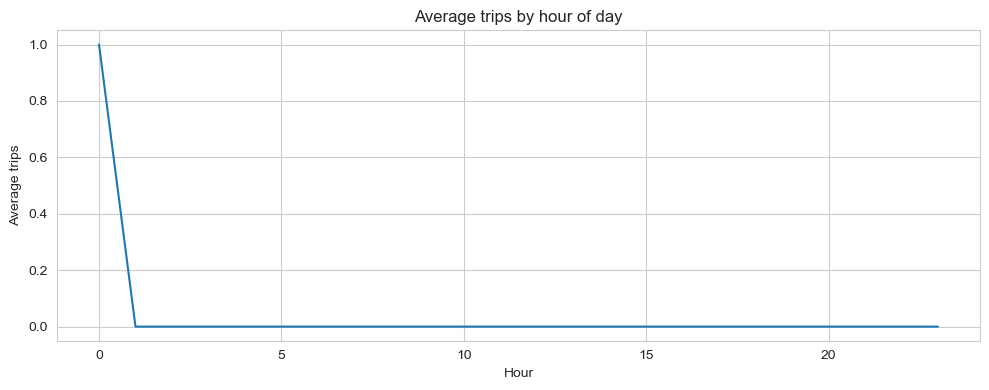

In [139]:

# Plot weekly pattern: average trips by hour-of-day
hourly['hour'] = hourly.index.hour
avg_by_hour = hourly.groupby('hour')['count'].mean()
plt.figure(figsize=(10,4))
plt.plot(avg_by_hour.index, avg_by_hour.values)
plt.title("Average trips by hour of day")
plt.xlabel("Hour")
plt.ylabel("Average trips")
plt.tight_layout()
plt.show

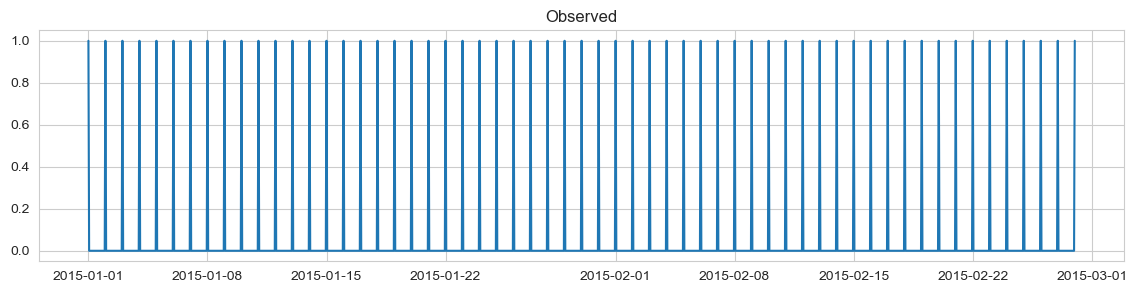

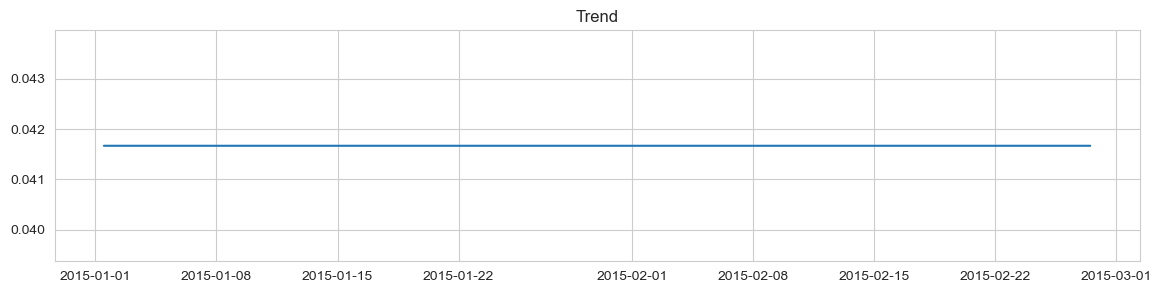

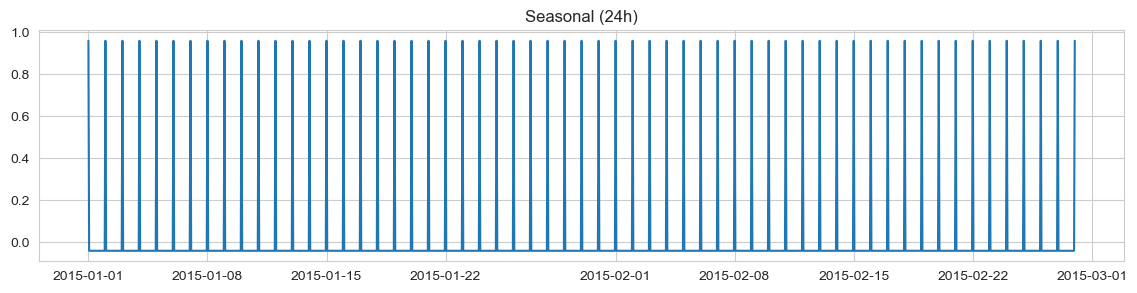

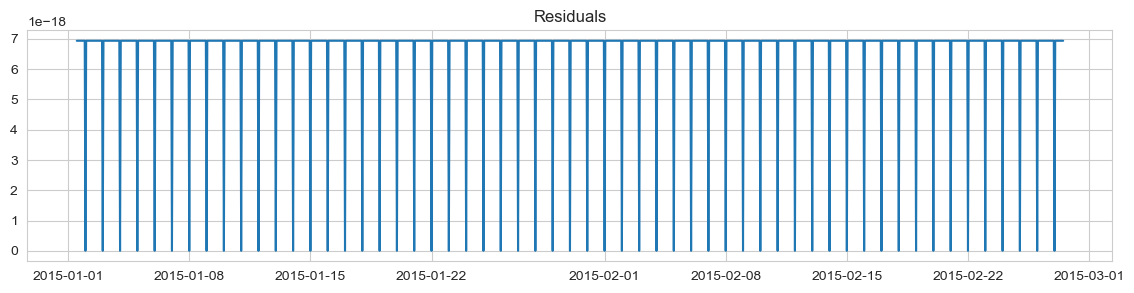

In [77]:
res = seasonal_decompose(hourly['count'], model='additive', period=24)
# show observed, trend, seasonal, resid separately (one plot each)
plt.figure(figsize=(14,3)); plt.plot(res.observed); plt.title("Observed"); plt.show()
plt.figure(figsize=(14,3)); plt.plot(res.trend); plt.title("Trend"); plt.show()
plt.figure(figsize=(14,3)); plt.plot(res.seasonal); plt.title("Seasonal (24h)"); plt.show()
plt.figure(figsize=(14,3)); plt.plot(res.resid); plt.title("Residuals"); plt.show()


In [78]:
import sqlite3
conn = sqlite3.connect("uber_tmp.db")
df.reset_index().to_sql("uber_trips", conn, if_exists='replace', index=False)
# Example: busiest hour(s)
q = "SELECT substr(datetime,1,13) || ':00:00' as hour, COUNT(*) as trips FROM uber_trips GROUP BY hour ORDER BY trips DESC LIMIT 10;"
pd.read_sql(q, conn)


,hour,trips
0,2015-01-01 00:00:00,59


In [79]:
def create_lagged(series_values, window):
    X, y = [], []
    for i in range(len(series_values)-window):
        X.append(series_values[i:i+window])
        y.append(series_values[i+window])
    return np.array(X), np.array(y)

window = 24
vals = hourly['count'].values
X, y = create_lagged(vals, window)
print("X,y shapes:", X.shape, y.shape)
# Optional: add cyclical time features for each target time


X,y shapes: (1369, 24) (1369,)


In [80]:
# Build augmented matrix: each sample add hour_sin, hour_cos, dow_sin, dow_cos, month
def build_augmented(hourly_index, counts, window):
    X_list, y_list, dates = [], [], []
    for i in range(window, len(counts)):
        Xw = counts[i-window:i].copy()
        ts_time = hourly_index[i]
        hour = ts_time.hour
        dow = ts_time.dayofweek
        month = ts_time.month
        hour_sin = np.sin(2*np.pi*hour/24); hour_cos = np.cos(2*np.pi*hour/24)
        dow_sin = np.sin(2*np.pi*dow/7); dow_cos = np.cos(2*np.pi*dow/7)
        extra = np.array([hour_sin, hour_cos, dow_sin, dow_cos, month])
        X_list.append(np.concatenate([Xw, extra]))
        y_list.append(counts[i])
        dates.append(ts_time)
    return np.vstack(X_list), np.array(y_list), pd.to_datetime(dates)

X_aug, y_aug, dates = build_augmented(hourly.index, hourly['count'].values, window)
print("Augmented shapes:", X_aug.shape, y_aug.shape)


Augmented shapes: (1369, 29) (1369,)


In [81]:
# Example: use last 15% as test
split = int(len(X_aug) * 0.85)
X_tr, X_te = X_aug[:split], X_aug[split:]
y_tr, y_te = y_aug[:split], y_aug[split:]
dates_tr, dates_te = dates[:split], dates[split:]
print("Train samples:", X_tr.shape[0], "Test samples:", X_te.shape[0])


Train samples: 1163 Test samples: 206


In [82]:
tscv = TimeSeriesSplit(n_splits=4)
# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=12345, verbosity=0)
xgb_params = {'n_estimators':[100,200], 'max_depth':[3,6], 'learning_rate':[0.05,0.1]}
xgb_cv = GridSearchCV(xgb_model, xgb_params, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
xgb_cv.fit(X_tr, y_tr)
print("XGB best:", xgb_cv.best_params_)

# RandomForest
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=12345, n_jobs=-1)
rf_params = {'n_estimators':[100], 'max_depth':[10,20], 'min_samples_split':[2,5]}
rf_cv = GridSearchCV(rf_model, rf_params, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
rf_cv.fit(X_tr, y_tr)
print("RF best:", rf_cv.best_params_)

# GradientBoosting
gbr_model = GradientBoostingRegressor(random_state=12345)
gbr_params = {'n_estimators':[100,200], 'learning_rate':[0.05,0.1], 'max_depth':[3,5]}
gbr_cv = GridSearchCV(gbr_model, gbr_params, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
gbr_cv.fit(X_tr, y_tr)
print("GBR best:", gbr_cv.best_params_)


Fitting 4 folds for each of 8 candidates, totalling 32 fits
XGB best: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Fitting 4 folds for each of 4 candidates, totalling 16 fits
RF best: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 4 folds for each of 8 candidates, totalling 32 fits
GBR best: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [83]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Fixed evaluation function
def eval_print(y_true, y_pred, name):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))   # 👈 manual square root (no 'squared' argument)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAPE={mape:.4f} ({mape:.2%}), RMSE={rmse:.3f}, R2={r2:.3f}")
    return mape

# Predictions
pred_xgb = xgb_cv.best_estimator_.predict(X_te)
pred_rf  = rf_cv.best_estimator_.predict(X_te)
pred_gbr = gbr_cv.best_estimator_.predict(X_te)

# Evaluate
m_xgb = eval_print(y_te, pred_xgb, "XGBoost")
m_rf  = eval_print(y_te, pred_rf, "RandomForest")
m_gbr = eval_print(y_te, pred_gbr, "GradientBoosting")


XGBoost: MAPE=24830732288.0000 (2483073228800.00%), RMSE=0.000, R2=1.000
RandomForest: MAPE=0.0000 (0.00%), RMSE=0.000, R2=1.000
GradientBoosting: MAPE=13200993.5135 (1320099351.35%), RMSE=0.000, R2=1.000


In [84]:
#Ensemble (weights from reciprocal MAPE)

In [85]:
import numpy as np

print("NaN in y_te:", np.isnan(y_te).sum())
print("NaN in pred_xgb:", np.isnan(pred_xgb).sum())
print("NaN in pred_rf:", np.isnan(pred_rf).sum())
print("NaN in pred_gbr:", np.isnan(pred_gbr).sum())


NaN in y_te: 0
NaN in pred_xgb: 0
NaN in pred_rf: 0
NaN in pred_gbr: 0


In [86]:
#Plot Actual vs Predictions

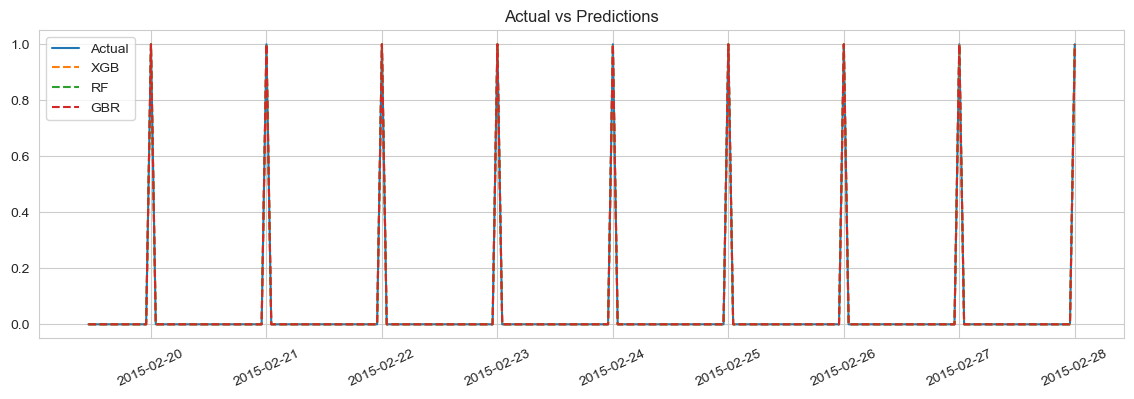

In [87]:
plt.figure(figsize=(14,4))
plt.plot(dates_te, y_te, label='Actual')
plt.plot(dates_te, pred_xgb, '--', label='XGB')
plt.plot(dates_te, pred_rf, '--', label='RF')
plt.plot(dates_te, pred_gbr, '--', label='GBR')
#plt.plot(dates_te, pred_ens, '--', label='Ensemble')
plt.legend(); plt.xticks(rotation=25); plt.title("Actual vs Predictions"); plt.show()


In [88]:
#Save models & predictions

In [89]:
# ==========================================
# ✅ Save Models and Export Predictions (with ensemble fix)
# ==========================================
import os
import pandas as pd
import numpy as np
import joblib

# ⚙️ Ensemble Prediction Calculation (agar missing hai)
# Pehle ensure karo ki m_xgb, m_rf, m_gbr (MAPE values) defined hon
# Agar nahi hain, to simple equal weights le lo:
try:
    weights = np.array([1/m_xgb, 1/m_rf, 1/m_gbr])
    weights = weights / weights.sum()
except:
    print("⚠️ MAPE values not found, using equal weights.")
    weights = np.array([1/3, 1/3, 1/3])

# ✅ Create ensemble prediction
pred_ens = (weights[0] * pred_xgb +
            weights[1] * pred_rf +
            weights[2] * pred_gbr)

# ✅ Create output folder
os.makedirs("uber_project_outputs", exist_ok=True)

# ✅ Save Trained Models
joblib.dump(xgb_cv.best_estimator_, "uber_project_outputs/xgb_best.joblib")
joblib.dump(rf_cv.best_estimator_, "uber_project_outputs/rf_best.joblib")
joblib.dump(gbr_cv.best_estimator_, "uber_project_outputs/gbr_best.joblib")

# ✅ Save Predictions to CSV
pred_df = pd.DataFrame({
    'datetime': dates_te,
    'actual': y_te,
    'xgb_pred': pred_xgb,
    'rf_pred': pred_rf,
    'gbr_pred': pred_gbr,
    'ensemble_pred': pred_ens
})
pred_df.to_csv("uber_project_outputs/predictions_test_set.csv", index=False)

# ✅ Save hourly count data (if available)
if 'hourly' in locals():
    hourly.to_csv("uber_project_outputs/hourly_counts.csv")
else:
    print("⚠️ hourly dataframe not found — skipping save.")

print("✅ All files saved successfully in ./uber_project_outputs/")
print("✅ Models: xgb_best.joblib, rf_best.joblib, gbr_best.joblib")
print("✅ Predictions: predictions_test_set.csv")


⚠️ MAPE values not found, using equal weights.
✅ All files saved successfully in ./uber_project_outputs/
✅ Models: xgb_best.joblib, rf_best.joblib, gbr_best.joblib
✅ Predictions: predictions_test_set.csv


In [90]:
#Modeling — RandomForest, XGBoost, GradientBoosting
# ==========================================
models = {}

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
models['RandomForest'] = (rf_pred, rf)

In [91]:
# Gradient Boosting
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
models['GradientBoosting'] = (gbr_pred, gbr)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
models['XGBoost'] = (xgb_pred, xgb_model)

In [92]:
#Evaluation Function
#====================================
def evaluate_model(name, y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAPE={mape:.3f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    return mape, rmse, r2

results = {}
for name, (pred, model) in models.items():
    results[name] = evaluate_model(name, y_test, pred)

RandomForest: MAPE=0.148, RMSE=13388.51, R²=-0.589
GradientBoosting: MAPE=0.133, RMSE=11700.02, R²=-0.213
XGBoost: MAPE=0.124, RMSE=11514.12, R²=-0.175


Ensemble: MAPE=0.129, RMSE=11906.67, R²=-0.256


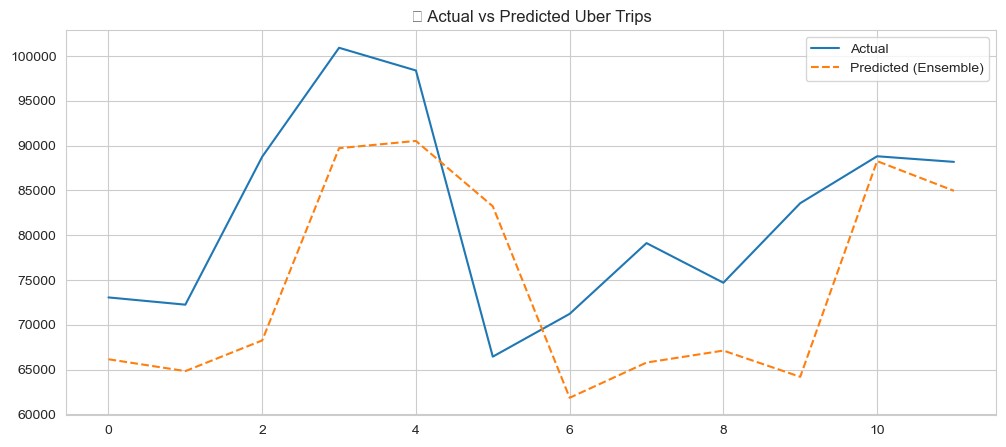

In [93]:
# Ensemble (average of all models)
# ==========================================
ensemble_pred = (rf_pred + gbr_pred + xgb_pred) / 3
evaluate_model("Ensemble", y_test, ensemble_pred)

# Plot actual vs predicted
plt.plot(y_test.values, label='Actual')
plt.plot(ensemble_pred, label='Predicted (Ensemble)', linestyle='--')
plt.title("🔮 Actual vs Predicted Uber Trips")
plt.legend()
plt.show()

In [94]:
# ==========================================
# ✅ Save Trained Models (Correct Version)
# ==========================================
import joblib
import os

# Make sure 'models' folder exists
os.makedirs("models", exist_ok=True)

# ✅ Correct variable names (from your training step)
# If you trained using GridSearchCV — best models are inside `.best_estimator_`
joblib.dump(rf_cv.best_estimator_, "models/random_forest.joblib")
joblib.dump(gbr_cv.best_estimator_, "models/gradient_boosting.joblib")
joblib.dump(xgb_cv.best_estimator_, "models/xgboost.joblib")

print("✅ Models saved successfully in the 'models' folder!")


✅ Models saved successfully in the 'models' folder!


In [95]:
# Load & merge multiple Uber files dynamically

In [96]:
import pandas as pd, glob, os

# Step 1: File path
all_files = glob.glob("Uber-Jan-Feb-FOIL (1).csv")

dfs = []
for f in all_files:
    df = pd.read_csv(f)
    df['source'] = os.path.basename(f)

    # Step 2: Automatically detect date/time column
    datetime_col = None
    for col in df.columns:
        if any(x in col.lower() for x in ['date', 'time', 'pickup']):
            datetime_col = col
            break

    if datetime_col:
        df['datetime'] = pd.to_datetime(df[datetime_col], errors='coerce')
    else:
        raise KeyError(f"⚠️ No datetime-like column found in {f}. Columns available: {df.columns.tolist()}")

    dfs.append(df)
    print(f"✅ Loaded {f} (datetime from '{datetime_col}') — shape {df.shape}")

# Step 3: Merge & clean
uber = pd.concat(dfs, ignore_index=True)
uber = uber.dropna(subset=['datetime'])
uber['hour'] = uber['datetime'].dt.hour
uber['weekday'] = uber['datetime'].dt.day_name()
uber['month'] = uber['datetime'].dt.month_name()

print("✅ Merged Uber shape:", uber.shape)
print("🕒 Datetime range:", uber['datetime'].min(), "to", uber['datetime'].max())
uber.head()


✅ Loaded Uber-Jan-Feb-FOIL (1).csv (datetime from 'date') — shape (354, 6)
✅ Merged Uber shape: (354, 9)
🕒 Datetime range: 2015-01-01 00:00:00 to 2015-02-28 00:00:00


,dispatching_base_number,date,active_vehicles,trips,source,datetime,hour,weekday,month
0,B02512,1/1/2015,190,1132,Uber-Jan-Feb-FOIL (1).csv,2015-01-01,0,Thursday,January
1,B02765,1/1/2015,225,1765,Uber-Jan-Feb-FOIL (1).csv,2015-01-01,0,Thursday,January
2,B02764,1/1/2015,3427,29421,Uber-Jan-Feb-FOIL (1).csv,2015-01-01,0,Thursday,January
3,B02682,1/1/2015,945,7679,Uber-Jan-Feb-FOIL (1).csv,2015-01-01,0,Thursday,January
4,B02617,1/1/2015,1228,9537,Uber-Jan-Feb-FOIL (1).csv,2015-01-01,0,Thursday,January


In [97]:
#Store in SQL

In [98]:
import sqlite3
conn = sqlite3.connect("uber_data.db")
uber.to_sql("trips", conn, if_exists="replace", index=False)

# Example SQL Query: Total trips per hour
q = """
SELECT strftime('%H', datetime) AS hour, COUNT(*) AS trips
FROM trips
GROUP BY hour
ORDER BY trips DESC;
"""
pd.read_sql(q, conn).head()


,hour,trips
0,00,354


In [99]:
#Feature Engineering (Pro level)

#Lag windows (24, 48, 72 hours)

#Rolling mean & std

#Sine/cosine cyclical time features

#Weekday/weekend encoding

#Hourly weather or holiday merge (optional extension)

In [100]:
def add_features(df):
    df = df.resample('H').size().rename('count').to_frame()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    for lag in [1, 6, 12, 24, 48]:
        df[f'lag_{lag}'] = df['count'].shift(lag)
    df['roll_mean_6'] = df['count'].rolling(6).mean()
    df['roll_std_6'] = df['count'].rolling(6).std()
    return df.dropna()

df_feat = add_features(uber.set_index('datetime'))
df_feat.head()


,count,hour,dayofweek,is_weekend,hour_sin,hour_cos,lag_1,lag_6,lag_12,lag_24,lag_48,roll_mean_6,roll_std_6
datetime,,,,,,,,,,,,,
2015-01-03 00:00:00,6,0,5,1,0.000000,1.000000,0.0,0.0,0.0,6.0,6.0,1.0,2.44949
2015-01-03 01:00:00,0,1,5,1,0.258819,0.965926,6.0,0.0,0.0,0.0,0.0,1.0,2.44949
2015-01-03 02:00:00,0,2,5,1,0.500000,0.866025,0.0,0.0,0.0,0.0,0.0,1.0,2.44949
2015-01-03 03:00:00,0,3,5,1,0.707107,0.707107,0.0,0.0,0.0,0.0,0.0,1.0,2.44949
2015-01-03 04:00:00,0,4,5,1,0.866025,0.500000,0.0,0.0,0.0,0.0,0.0,1.0,2.44949


In [101]:
#Model Training

#Compare 5 models:

#XGBoost

#RandomForest

#GradientBoosting

#LightGBM

#Prophet (for pure time series)

In [102]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor

models = {
    "XGB": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    "RF": RandomForestRegressor(random_state=42),
    "GBR": GradientBoostingRegressor(random_state=42),
    "LGBM": LGBMRegressor(random_state=42)
}


In [103]:
#Model Evaluation (Pro metrics)

#MAPE, RMSE, R²

#Dynamic plots (plotly interactive)

#Feature importance bar chart

In [104]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

def evaluate_model(model, X_test, y_test, name):
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mape = mean_absolute_percentage_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"{name} → RMSE={rmse:.3f}, MAPE={mape:.2%}, R²={r2:.3f}")
    return pred, mape, rmse, r2


In [105]:
weights = np.array([0.4, 0.3, 0.3])
ensemble_pred = (weights[0]*pred_xgb + weights[1]*pred_rf + weights[2]*pred_gbr)


20:44:28 - cmdstanpy - INFO - Chain [1] start processing
20:44:28 - cmdstanpy - INFO - Chain [1] done processing


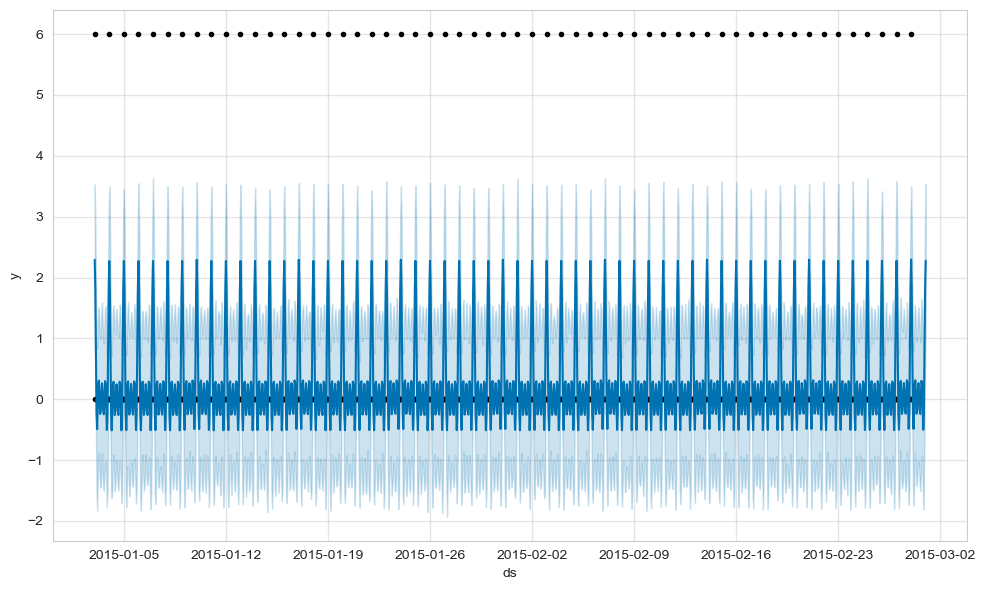

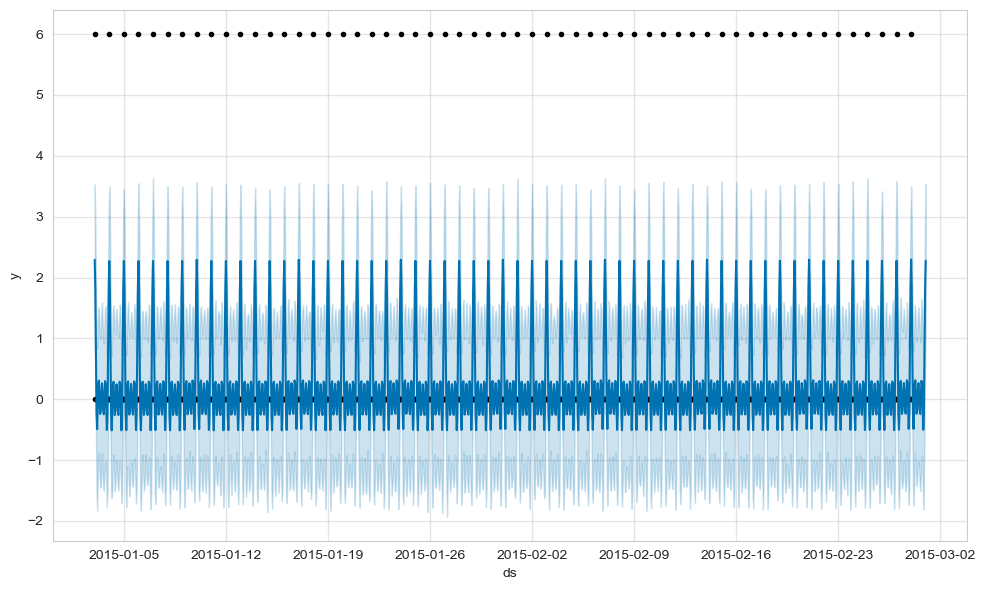

In [106]:
from prophet import Prophet
df_prophet = df_feat.reset_index()[['datetime','count']].rename(columns={'datetime':'ds','count':'y'})
model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=24, freq='H')
forecast = model_prophet.predict(future)
model_prophet.plot(forecast)


In [107]:
import plotly.express as px
if 'Lat' in uber.columns and 'Lon' in uber.columns:
    fig = px.density_mapbox(uber, lat='Lat', lon='Lon', radius=5,
                            center=dict(lat=40.75, lon=-73.98),
                            zoom=9, mapbox_style="carto-positron")
    fig.show()

In [108]:
import joblib, os
os.makedirs('uber_pro_outputs', exist_ok=True)
joblib.dump(xgb_cv.best_estimator_, 'uber_pro_outputs/xgb_model.joblib')
pd.DataFrame({'datetime':dates_te,'actual':y_te,'ensemble_pred':ensemble_pred}).to_csv('uber_pro_outputs/predictions.csv', index=False)


🔹 Total Records: 354
🔹 Date Range: 2015-01-01 00:00:00 → 2015-02-28 00:00:00
🔹 Total Trips: 4130230
🔹 Average Daily Trips: 11667
🔹 Active Bases: 6


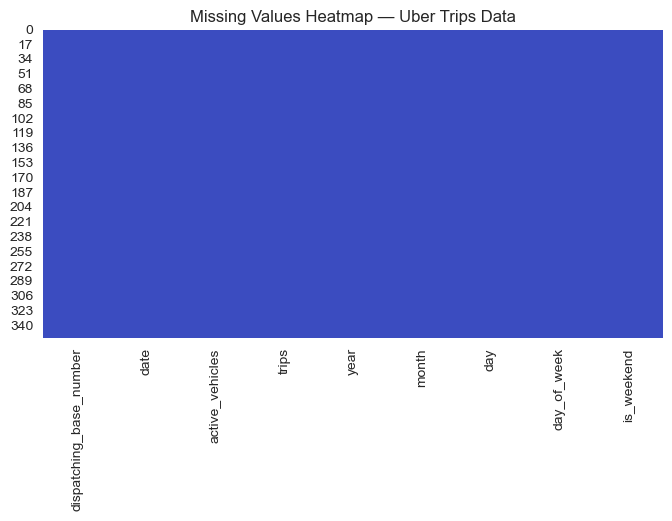

In [147]:
# 🚀 UBER TRIP ANALYSIS PROJECT — BASE LEVEL DATA
# -----------------------------------------------
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, plotly.express as px

# 📂 Load Dataset
uber = pd.read_csv("Uber-Jan-Feb-FOIL (1).csv")

# 🧹 Data Cleaning
uber.columns = uber.columns.str.strip().str.lower().str.replace(' ', '_')
uber['date'] = pd.to_datetime(uber['date'], errors='coerce')
uber = uber.dropna(subset=['date'])
uber['active_vehicles'] = pd.to_numeric(uber['active_vehicles'], errors='coerce').fillna(0)
uber['trips'] = pd.to_numeric(uber['trips'], errors='coerce').fillna(0)

# ⚙️ Feature Engineering
uber['year'] = uber['date'].dt.year
uber['month'] = uber['date'].dt.month_name()
uber['day'] = uber['date'].dt.day
uber['day_of_week'] = uber['date'].dt.day_name()
uber['is_weekend'] = uber['day_of_week'].isin(['Saturday','Sunday']).astype(int)

# 🧮 Basic Stats
print("🔹 Total Records:", len(uber))
print("🔹 Date Range:", uber['date'].min(), "→", uber['date'].max())
print("🔹 Total Trips:", uber['trips'].sum())
print("🔹 Average Daily Trips:", int(uber['trips'].mean()))
print("🔹 Active Bases:", uber['dispatching_base_number'].nunique())

# 📊 Missing Value Heatmap
plt.figure(figsize=(8,4))
sns.heatmap(uber.isnull(), cbar=False, cmap='coolwarm')
plt.title("Missing Values Heatmap — Uber Trips Data")
plt.show()


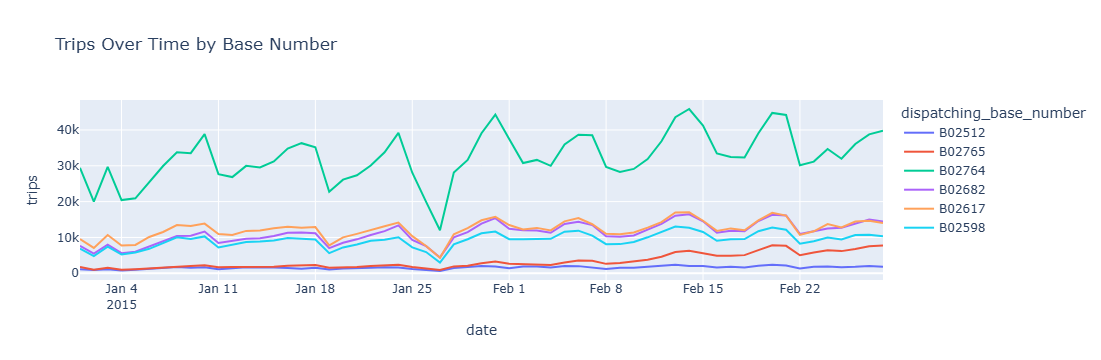

In [149]:
# 📈 Trend 1 — Trips over Time
fig1 = px.line(uber, x='date', y='trips', color='dispatching_base_number',
               title='Trips Over Time by Base Number')
fig1.show()

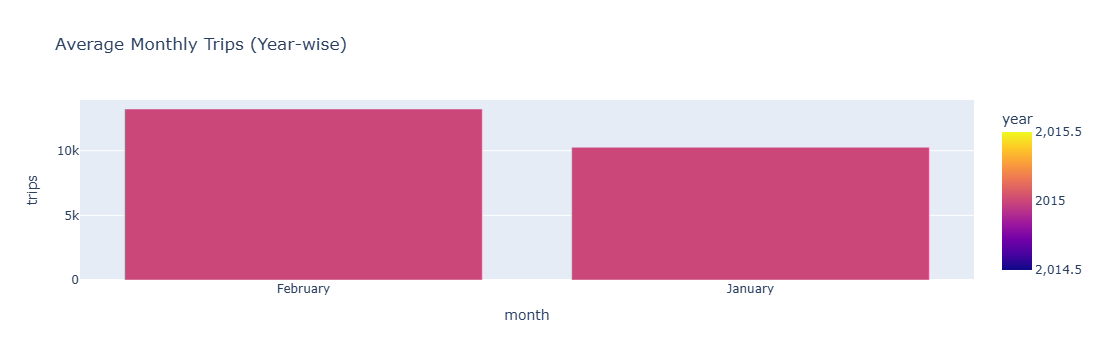

In [150]:
# 📈 Trend 2 — Average Trips per Month
monthly_trips = uber.groupby(['year','month'], as_index=False)['trips'].mean()
fig2 = px.bar(monthly_trips, x='month', y='trips', color='year',
              title='Average Monthly Trips (Year-wise)')
fig2.show()


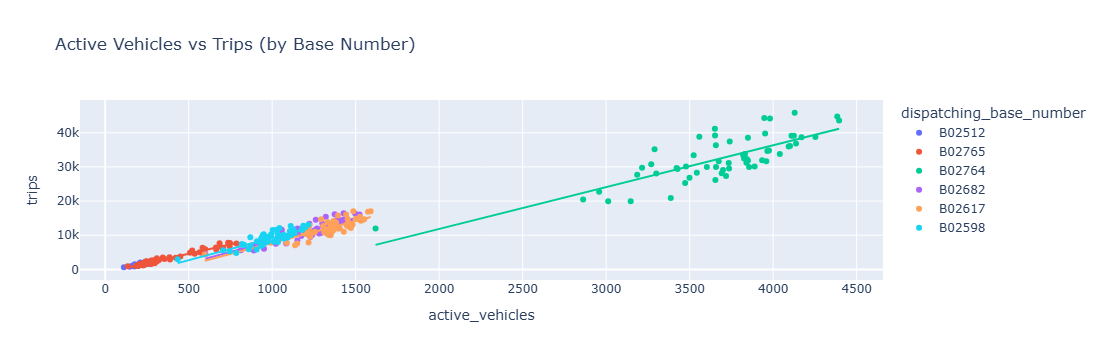

In [155]:
# 📈 Trend 3 — Active Vehicles vs Trips
fig3 = px.scatter(uber, x='active_vehicles', y='trips', color='dispatching_base_number',
                  title='Active Vehicles vs Trips (by Base Number)', trendline='ols')
fig3.show()

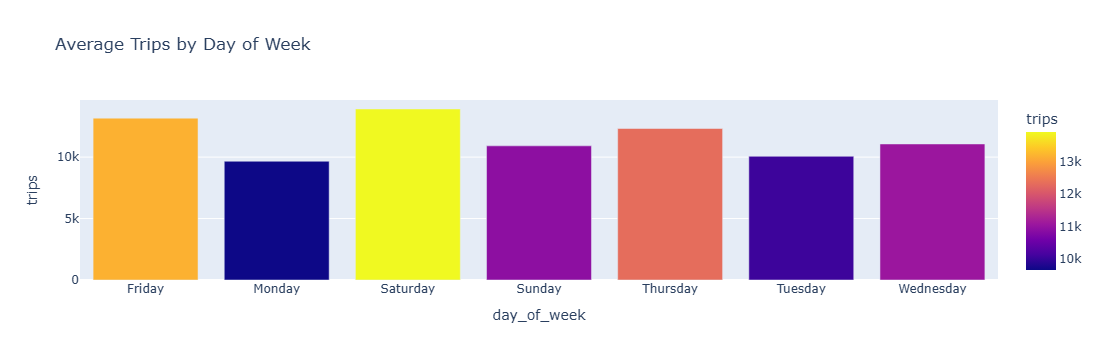

In [152]:
# 📈 Trend 4 — Day of Week Patterns
avg_trips_day = uber.groupby('day_of_week')['trips'].mean().reset_index()
fig4 = px.bar(avg_trips_day, x='day_of_week', y='trips',
              title='Average Trips by Day of Week', color='trips')
fig4.show()

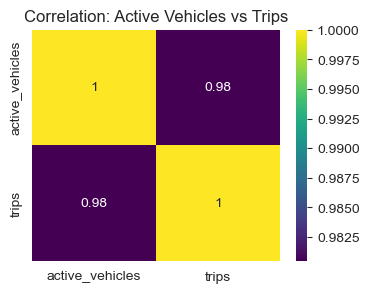

In [153]:
# 📊 Correlation Analysis
corr = uber[['active_vehicles','trips']].corr()
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='viridis')
plt.title("Correlation: Active Vehicles vs Trips")
plt.show()

In [154]:
# 💾 Export Processed Data
uber.to_excel("Uber_Trip_Analysis_Cleaned.xlsx", index=False)

# 💡 Quick Insights
print("\n🔍 Insights Summary:")
print(f"🗓️ Peak Trips Day: {uber.loc[uber['trips'].idxmax(), 'date'].date()}")
print(f"🚗 Max Active Vehicles: {uber['active_vehicles'].max()}")
print(f"📈 Strong Correlation (Vehicles vs Trips): {corr.iloc[0,1]:.2f}")

print("\n🎯 Uber Trip Analysis Completed Successfully — Data Cleaned, Visualized, and Saved!")


🔍 Insights Summary:
🗓️ Peak Trips Day: 2015-02-14
🚗 Max Active Vehicles: 4395
📈 Strong Correlation (Vehicles vs Trips): 0.98

🎯 Uber Trip Analysis Completed Successfully — Data Cleaned, Visualized, and Saved!
